# Backpropagation Lab





In [73]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
import pandas as pd
import copy
from sklearn.model_selection import train_test_split

## 1. (40%) Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with mean of 0 and a variance of 1.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e., do not attempt batch updates)
- Implement a validation set based stopping criterion.
- Shuffle training set at each epoch.
- Option to include a momentum term

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [244]:
from numpy.random.mtrand import shuffle
from re import I
class MLP(BaseEstimator,ClassifierMixin):

    def __init__(self,lr=.1, momentum=0, shuffle=True, hidden_layer_widths=None, num_inputs=1, num_outputs=1, one_hot=True):
        self.hidden_layer_widths = hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        # Dictionary to hold things like MSE, validation/train accuracy for use outside of class
        self.results = {}
        self.results['training'] = []
        self.results['validation'] = []
        self.results['mse_training'] = []
        self.results['mse_validation'] = []
        self.results['mse_validation_no_epoch'] = []
        self.results['mse_training_no_epoch'] = []
        self.results['epochs'] = []

        if self.hidden_layer_widths is None:
          self.layers = [self.num_inputs] + [2*num_inputs] + [self.num_outputs]
        else:
          self.layers = [self.num_inputs] + self.hidden_layer_widths + [self.num_outputs]
          
        
        self.weights = []
        self.delta_weights = []

        self.one_hot = one_hot

        activations = []
        for i in range(len(self.layers)):
          a = np.zeros(self.layers[i])
          activations.append(a)
        self.activations = activations

        derivatives = []
        for i in range(len(self.layers)-1):
          d = np.zeros((self.layers[i],self.layers[i+1]))
          derivatives.append(a)
        self.derivatives = derivatives

    def fit(self, X, y, initial_weights=None, epochs=-1, zeros=False, one_hot=False, validation_percent=0):
        
        # Initialize weights and delta weights array
        self.weights = self.initialize_weights(X, zeros) if initial_weights is None else initial_weights
        self.delta_weights = self.initialize_weights(X, zeros)

        # Create validation set from training set
        if validation_percent > 0:
          X, X_val, y, y_val = train_test_split(X, y, test_size=validation_percent, random_state=42)


        # Set up stopping criteria - if max validation accuracy value does not change in 5 epochs
        prev_val_accuracy = 0
        iterations_no_change = 0



        # Initialize epoch counter
        epoch = 1

        # Iterate for set number of epochs
        while True:
          #print("\n\n\nEpoch #", epoch)

          mse_sum = 0

          #print("Weights before epoch " + str(e) + " training: \n", self.weights)
          for i in range(len(X)):
            input = X[i]
            target = y[i]

            # Main training loop - forward -> back_prop -> gradient_descent
            output = self.forward_pass(input)
            error = target - output
            self.back_propagate(error)
            self.gradient_descent()

            # Calculate means squared for current entry
            mse_sum += np.mean((target-output)**2)

          # Tasks to do between each epoch
          self.results.get('epochs').append(epoch-1)

          # Save mse for epoch to results
          self.results.get('mse_training').append([epoch-1, mse_sum/len(X)])
          self.results.get('mse_training_no_epoch').append(mse_sum/len(X))

          # Calculate Means Squared Error for epoch
          training_accuracy = self.score(self.predict(X), y)
          self.results.get('training').append([epoch-1, training_accuracy])


          # Check validation set
          if validation_percent > 0:
            validation_accuracy = self.score(self.predict(X_val), y_val)
            #print("Validation Accuracy: ", validation_accuracy)

            self.results.get('validation').append([epoch-1, validation_accuracy])

            # Get MSE for validation set
            predictions = self.predict(X_val)

            val_mse = np.mean((y_val - predictions)**2)
            self.results.get('mse_validation').append([epoch-1, val_mse])
            self.results.get('mse_validation_no_epoch').append(val_mse)
            #print("Change in accuracy: ", validation_accuracy - prev_val_accuracy)

            # Check if validation accuracy changed. If not, count iteration
            if validation_accuracy - prev_val_accuracy < 0.02:
              iterations_no_change += 1
              prev_val_accuracy = validation_accuracy
            else: # Validation accuracy changed, restart stopping count
              prev_val_accuracy = validation_accuracy
              iterations_no_change = 0

          # Check for validation set accuracy stopping criteria
          if iterations_no_change == 5:
            break


          # Check if epoch count is reached
          if epoch == epochs:
            break

          # Iterate epoch count
          epoch += 1

          # TODO: Shuffle data sets for next iteration
          if self.shuffle:
            X, y = self._shuffle_data(X,y)

        return self

    def forward_pass(self, input):

      activations = input
      activations = np.append(activations, 1)
      self.activations[0] = activations

      for i, w in enumerate(self.weights):
        # Calculate net inputs
        net_input = np.dot(activations, w)

        # Calculate activations
        activations = self._sigmoid(net_input)
        if i != len(self.weights) - 1:
          activations = np.append(activations, 1)

        self.activations[i+1] = activations

      return activations

    def back_propagate(self, error, verbose=False):

      for i in reversed(range(len(self.derivatives))):
        activations = self.activations[i+1]

        # Calculating output layer
        delta = error * self._sigmoid_derivative(activations)

        if i != len(self.derivatives) - 1:
          delta = delta[:-1]

        delta_reshaped = delta.reshape(delta.shape[0], -1).T

        current_activations = self.activations[i]
        current_activations_reshaped = current_activations.reshape(current_activations.shape[0], -1)

        self.derivatives[i] = np.dot(current_activations_reshaped, delta_reshaped)

        error = np.dot(delta, self.weights[i].T)


      return error

    def gradient_descent(self):

      old_weights = copy.deepcopy(self.weights)

      for i in range(len(self.weights)):

        weights = self.weights[i]
        

        derivatives = self.derivatives[i]

        weights += (derivatives * self.lr) + (self.momentum*self.delta_weights[i])

      for index in range(len(self.weights)):
        self.delta_weights[index] = np.subtract(self.weights[index], old_weights[index])


    def _sigmoid(self, x):
      return 1.0 /(1 + np.exp(-x))

    def _sigmoid_derivative(self, x):
      return x * (1.0 - x)

      
    def predict(self, X):
        predictions = []
        
        for input in (X):
          prediction = self.forward_pass(input)

          # Convert prediction into one hot prediction from probabilities
          guess = np.argmax(prediction)

          for i in range(len(prediction)):
            if i == guess:
              prediction[i] = 1
            else:
              prediction[i] = 0

          predictions.append(prediction)

        return predictions

    def initialize_weights(self, X, zeros=False):
        weights = []

        for i in range(len(self.layers) - 1):
          if zeros:
            w = np.zeros((self.layers[i]+1, self.layers[i+1]))
          else:
            w = np.random.normal(0, 1, (self.layers[i]+1, self.layers[i+1]))
          weights.append(w)

        return weights
    def score(self, X, y):
        correct = 0
        total = 0

        for i in range(len(X)):
          predicted_out = np.argmax(X[i])
          actual_out = np.argmax(y[i])

          if predicted_out == actual_out:
            correct += 1

          total += 1

        return (correct/total)

    def _shuffle_data(self, X, y):

      y_len = len(y[0])

      combined = np.concatenate((X,y),axis=1)
      

      np.random.shuffle(combined)

      data_len = len(combined[0])
      stop_index = data_len - y_len
      
      
      X = [row[:stop_index] for row in combined]
      y = [row[stop_index:] for row in combined]



      return X,y

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

    def get_results(self):
      return self.results


## 1.1 

Debug your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 Debug 

Debug your model by running it on the [Debug Dataset](https://byu.instructure.com/courses/14142/files?preview=4421290)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://byu.instructure.com/courses/14142/files?preview=4537323) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://byu.instructure.com/courses/14142/files?preview=4537340) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

In [311]:
raw_data = loadarff('linsep2nonorigin.arff')
dataset = pd.DataFrame(raw_data[0])
X = dataset._get_numeric_data().to_numpy()

# Turn y into one hot encoding vector
y = dataset["class"].astype(int).to_numpy()
y = pd.get_dummies(y).astype(int).to_numpy()

model = MLP(hidden_layer_widths=[4], momentum=.5, lr=.1, num_inputs=len(X[0]), num_outputs=len(y[0]), shuffle=False)

n_epochs = 10
model = model.fit(X, y, epochs=n_epochs, zeros=True)


# Print weights
print("\nFinal Weights")
print(model.get_weights())


Final Weights
[array([[-0.00018149, -0.00018149, -0.00018149, -0.00018149],
       [ 0.00157468,  0.00157468,  0.00157468,  0.00157468],
       [-0.00788218, -0.00788218, -0.00788218, -0.00788218]]), array([[ 0.01050642, -0.01050642],
       [ 0.01050642, -0.01050642],
       [ 0.01050642, -0.01050642],
       [ 0.01050642, -0.01050642],
       [ 0.02148778, -0.02148778]])]


### 1.1.2 Evaluation

Evaluate your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

We will evaluate your model based on printed weights after training on the [Evaluation Dataset](https://byu.instructure.com/courses/14142/files?preview=4421294)

In [313]:
raw_data = loadarff('data_banknote_authentication.arff')
dataset = pd.DataFrame(raw_data[0])
X = dataset._get_numeric_data().to_numpy()
y = dataset["class"].astype(int).to_numpy()
y = pd.get_dummies(y).astype(int).to_numpy()

model = MLP(hidden_layer_widths=[4], momentum=.5, lr=.1, num_inputs=len(X[0]), num_outputs=len(y[0]), shuffle=False)

n_epochs = 10

model = model.fit(X, y, epochs=n_epochs, zeros=True)

# Print weights
print("\nFinal Weights")
print(model.get_weights())


Final Weights
[array([[ 1.63828721,  1.63828721,  1.63828721,  1.63828721],
       [ 1.09612249,  1.09612249,  1.09612249,  1.09612249],
       [ 1.23447594,  1.23447594,  1.23447594,  1.23447594],
       [ 0.39269487,  0.39269487,  0.39269487,  0.39269487],
       [-2.09316151, -2.09316151, -2.09316151, -2.09316151]]), array([[ 1.81695611, -1.81695611],
       [ 1.81695611, -1.81695611],
       [ 1.81695611, -1.81695611],
       [ 1.81695611, -1.81695611],
       [-4.17098071,  4.17098071]])]


## 2. (10%) Backpropagation on the Iris Classification problem.

Load the Iris Dataset [Iris Dataset](https://byu.instructure.com/courses/14142/files?preview=4421369)

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Create one graph with MSE (mean squared error) over epochs from the training set and validation set
- Create one graph with classification accuracy (% classified correctly) over epochs from the training set and validation set
- Print out your test set accuracy

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

In [198]:
# Iris Classification
raw_data = loadarff('iris.arff')
dataset = pd.DataFrame(raw_data[0])

X = dataset._get_numeric_data().to_numpy()
y = dataset["class"].to_numpy()
y = pd.get_dummies(y).astype(int).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MLP(hidden_layer_widths=None, momentum=.5, lr=.1, num_inputs=len(X[0]), num_outputs=len(y[0]))

n_epochs = -1

model = model.fit(X_train, y_train, epochs=n_epochs, zeros=False, validation_percent=.15)

# Print weights
print("\nFinal Weights")
print(model.get_weights())

print("Model accuracy on test data: ", model.score(model.predict(X_test), y_test))






Epoch # 1
Validation Accuracy:  0.7222222222222222
Change in accuracy:  0.7222222222222222



Epoch # 2
Validation Accuracy:  0.5555555555555556
Change in accuracy:  -0.16666666666666663



Epoch # 3
Validation Accuracy:  0.5555555555555556
Change in accuracy:  0.0



Epoch # 4
Validation Accuracy:  0.5555555555555556
Change in accuracy:  0.0



Epoch # 5
Validation Accuracy:  0.5555555555555556
Change in accuracy:  0.0



Epoch # 6
Validation Accuracy:  0.9444444444444444
Change in accuracy:  0.38888888888888884



Epoch # 7
Validation Accuracy:  0.6111111111111112
Change in accuracy:  -0.33333333333333326



Epoch # 8
Validation Accuracy:  0.6111111111111112
Change in accuracy:  0.0



Epoch # 9
Validation Accuracy:  0.7777777777777778
Change in accuracy:  0.16666666666666663



Epoch # 10
Validation Accuracy:  0.9444444444444444
Change in accuracy:  0.16666666666666663



Epoch # 11
Validation Accuracy:  0.8333333333333334
Change in accuracy:  -0.11111111111111105



Epoch # 12
V

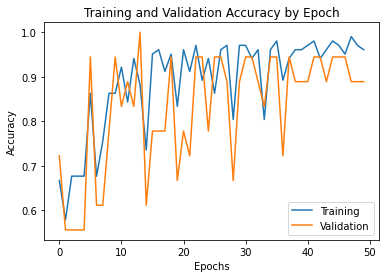

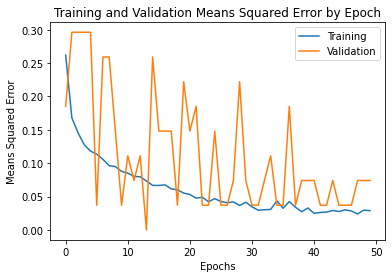

In [199]:
# Get results dictionary from model
results = model.get_results()

# Get accuracy values from results dictionary
training_accuracy = results.get('training')
validation_accuracy = results.get('validation')

# Zip up accuracy values
x1,y1 = zip(*training_accuracy)
x2,y2 = zip(*validation_accuracy)

# Plot accuracy graph
plt.plot(x1,y1, label="Training")
plt.plot(x2,y2, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy by Epoch")
plt.legend()
plt.show()

# Get MSE values from results dictionary
training_mse = results.get('mse_training')
validation_mse = results.get('mse_validation')

# Zip up MSE/epoch values

# Plot MSE graph
x1,y1 = zip(*training_mse)
x2,y2 = zip(*validation_mse)

# Plot accuracy graph
plt.plot(x1,y1, label="Training")
plt.plot(x2,y2, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Means Squared Error")
plt.title("Training and Validation Means Squared Error by Epoch")
plt.legend()
plt.show()


## 3. (10%) Working with the Vowel Dataset - Learning Rate

Load the Vowel Dataset [Vowel Dataset](https://byu.instructure.com/courses/14142/files?preview=4537354)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 80/20 splits of the data for the training/test set.
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Try some different learning rates (LR). Note that each LR will probably require a different number of epochs to learn. 

- For each LR you test, plot their validation's set MSE over Epochs on the same graph. Graph 4-5 different LRs and make them different enough to see a difference between them.

In general, whenever you are testing a parameter such as LR, # of hidden nodes, etc., test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

If you would like you may average the results of multiple initial conditions (e.g. 3) per LR, and that obviously would give more accurate results.

<img src=https://raw.githubusercontent.com/cs472ta/CS472/master/images/backpropagation/backprop_val_set_MSE_vs_epochs.png width=500 height=500  align="left">

In [201]:
learning_rates = [0.01, 0.1, 0.25, 0.5, 1.0]
lr_test_results = {}

for rate in learning_rates:
  # Train on each dataset
  raw_data = loadarff('vowel.arff')
  dataset = pd.DataFrame(raw_data[0])

  X = dataset._get_numeric_data().to_numpy()
  y = dataset["Class"].to_numpy()
  y = pd.get_dummies(y).astype(int).to_numpy()

  split_random_state = np.random.randint(1, high=100)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_random_state)

  model = MLP(hidden_layer_widths=None, momentum=.5, lr=rate, num_inputs=len(X[0]), num_outputs=len(y[0]))

  n_epochs = -1

  model = model.fit(X_train, y_train, epochs=n_epochs, zeros=False, validation_percent=.15)

  # Print weights and test set accuracy values
  print("\nFinal Weights")
  print(model.get_weights())

  print("Model accuracy on test data: ", model.score(model.predict(X_test), y_test))

  # Save results of tests for each learning rate to dictionary
  lr_test_results[rate] = model.get_results()

    Train or Test Speaker Number        Sex  ...  Feature 8  Feature 9   Class
0        b'Train'      b'Andrew'    b'Male'  ...     -0.874     -0.814  b'hid'
1        b'Train'      b'Andrew'    b'Male'  ...     -0.621     -0.488  b'hId'
2        b'Train'      b'Andrew'    b'Male'  ...     -0.809     -0.049  b'hEd'
3        b'Train'      b'Andrew'    b'Male'  ...     -0.091     -0.795  b'hAd'
4        b'Train'      b'Andrew'    b'Male'  ...      0.277     -0.396  b'hYd'
..            ...            ...        ...  ...        ...        ...     ...
985       b'Test'       b'Wendy'  b'Female'  ...     -0.914      0.147  b'hOd'
986       b'Test'       b'Wendy'  b'Female'  ...     -0.835     -0.301  b'hod'
987       b'Test'       b'Wendy'  b'Female'  ...     -0.773     -0.500  b'hUd'
988       b'Test'       b'Wendy'  b'Female'  ...     -0.863     -0.390  b'hud'
989       b'Test'       b'Wendy'  b'Female'  ...     -1.046      0.697  b'hed'

[990 rows x 14 columns]
[[-3.639  0.418 -0.67  ... 

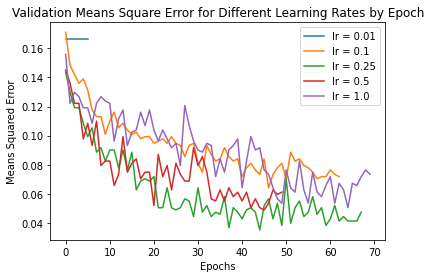

In [203]:
# Graph Validation Set MSE for each learning rate

for rate in learning_rates:
  results_dict = lr_test_results.get(rate)
  val_mse = results_dict.get('mse_validation')
  x1,y1 = zip(*val_mse)
  plt.plot(x1,y1, label="lr = " + str(rate))


plt.xlabel("Epochs")
plt.ylabel("Means Squared Error")
plt.title("Validation Means Square Error for Different Learning Rates by Epoch")
plt.legend()
plt.show()



## Learning Rate Test:

Ranked in order from worst to best

5th place: 0.01
4th place: 1.0
3th place: 0.1
2nd place: 0.5
1st place: 0.25

## 3.1 (5%) Working with the Vowel Dataset - Intuition
- Discuss the effect of varying learning rates. 
- Discuss why the vowel data set might be more difficult than Iris
    - Report both datasets' baseline accuracies and best **test** set accuracies. 
- Consider which of the vowel dataset's given input features you should actually use (Train/test, speaker, gender, ect) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.



1) Learning rate affects the results of the multilayer perceptron training because it controls how large of a "step" is taken based on the error gradients calculated. With that considered, it makes sense why the best learning rate varies by problem but is usually in a sweet spot of not too low but not too high at the same time. 

With a low learning rate, the algorithm has a hard time escaping local minima on the error gradients. This is seen in my test results when lr=.01 performed worst by all metrics, and had just 8% test set accuracy and a very short run time. It simply could not get out of the initial place on the gradient that the randomized weights started at. lr=.1 (the default value for the algorithm) performed a bit better with 54% test accuracy, but it similarly could not quite continue down the gradient after a certain point.

On the other hand, with a high learning rate, the algorithm can not settle into minima and continues to overshoot as it tries to descent the gradient. Lr=1 performed similarly to lr=.1 with 56% accuracy on the test data while lr=.5 faired slightly better with 61% test accuracy. On the validation accuracy graph, both of these learning rates show constant spikes up and down, an indication that the learning rate is making adjustments that are too large for it to settle into a minimun on the gradient.

My best result, lr=.25 falls right in the middle of these other values. It is large enough to make progress down the gradient without getting too stuck, while not large enough to where it overcorrects. This is shown by the best test accuracy results with 71%.

2) The Vowel dataset is harder than the Iris data set since it has many more input features, and many more output classes than the Iris data. The Iris data had 4 input features and 3 output classes, as well as only 150 data entries, making for a fairly simple data set. The Vowel data set has 12 input features (depending on how many get used for calculations) and 11 possible output classes, resulting in a much more complex computational problem. Since I am using one hot encodings of target values, the algorithm outputs a probability vector of the likelihood of the input being each class. With only 3 output classes, the probabilities have a smaller chance of being close together, so there is much more wiggle room for adjustment of the weights that can still get the correct answer. With more output classes, the probabilities are split many more ways, so the difference between the perceptron labeling an input one class or another can change with a tiny tweak of the weights. This makes the learning rate even more important for a dataset like this, since the probabilities are much more sensitive to change than in the Iris data set.

3) For my tests, I used the 9 numerical feature values from the array. The biggest reason for this is practical, it is very easy to get numerical data from a pandas dataframe, and that data is already ready to plug and play with the algorithm. Since the other values were not numerical, after extraction, they would need to be codified and adjusted which is at best time consuming and at worst hard to impossible to classify in a useful way. 

Despite my test results seeming good after seeing the accuracy values for each learning rate, I think that I probably could have added the male/female values to the input values if I were to do it again. They are easy to classify (1 for male, 0 for female or vice versa), and it could be interesting to see if that particular factor impacted the outputs. I don't think the other two data features "Train/test" and "speaker" are necessary. Since we are doing our own train/test split partitions, there's no need to use the labels that came with the data. Training and test data is all the same, except the fact that the model never touches test data until the end, so its okay to use the data in a different way than it is labeled in this case. I don't think speaker is necessary because not only is there no good way to apply it computational to this problem (each name could be a class in a one hot vector, but that adds a lot of extra dimensions to the input vector), but it also doesn't seem like a variable that is significant in statistical analysis. The speaker should be recorded in the data so researchers can know more about the specific data point when looking back, but I don't think the machine learning algorithm can do very much with that knowledge, especially since there is not any good way to codify it for this input style.




Test Accuracy for lr = 0.01 was 8.1
Test Accuracy for lr = 0.1 was 54.0
Test Accuracy for lr = 0.25 was 71.2
Test Accuracy for lr = 0.5 was 61.1
Test Accuracy for lr = 1.0 was 55.6


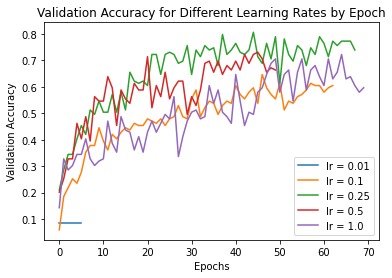

In [225]:
# Graph Validation Set MSE for each learning rate
test_accuracies = [8.1, 54.0, 71.2, 61.1, 55.6]

for index, rate in enumerate(learning_rates):
  results_dict = lr_test_results.get(rate)
  val_accuracy = results_dict.get('validation')
  x1,y1 = zip(*val_accuracy)
  plt.plot(x1,y1, label="lr = " + str(rate))

  print("Test Accuracy for lr = " + str(rate) + " was " + str(test_accuracies[index]))


plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy for Different Learning Rates by Epoch")
plt.legend()
plt.show()

## 3.2 (10%) Working with the Vowel Dataset - Hidden Layer Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create one graph with MSE for the training set and validation set on the y-axis and # of hidden nodes on the x-axis.
- Report the final test set accuracy for every # of hidden nodes you experimented on

In [227]:
# Train on each dataset
hidden_layer_results = {}
hidden_values = []

prev_val_mse = np.inf
current_val_mse = 0
num_hidden = 1

while True:
  # Train on each dataset
  raw_data = loadarff('vowel.arff')
  dataset = pd.DataFrame(raw_data[0])

  X = dataset._get_numeric_data().to_numpy()
  y = dataset["Class"].to_numpy()
  y = pd.get_dummies(y).astype(int).to_numpy()

  print("\nNum Hidden Nodes: ", num_hidden)

  split_random_state = np.random.randint(1, high=100)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_random_state)

  model = MLP(hidden_layer_widths=[num_hidden], momentum=.5, lr=.25, num_inputs=len(X[0]), num_outputs=len(y[0]))

  n_epochs = -1
  model = model.fit(X_train, y_train, epochs=n_epochs, zeros=False, validation_percent=.15)

  print("Model accuracy on test data: ", model.score(model.predict(X_test), y_test))


  hidden_values.append(num_hidden)
  
  results = model.get_results()
  hidden_layer_results[num_hidden] = results

  # Get Validation MSE array
  val_mse = results.get('mse_validation_no_epoch')
  min_index = np.argmin(val_mse)

  # Get best mse value from current results
  current_val_mse = val_mse[min_index]

  print("Previous best mse: ", prev_val_mse)
  print("Current best mse: ", current_val_mse)

  # Check if this test improved over the past one, if not, break
  if current_val_mse < prev_val_mse:
    prev_val_mse = current_val_mse
    num_hidden *= 2
  else:
    break


  # Save results of tests for each hidden node value to dictionary
  hidden_layer_results[num_hidden] = model.get_results()


Num Hidden Nodes:  1



Epoch # 1
Validation Accuracy:  0.07563025210084033
Change in accuracy:  0.07563025210084033



Epoch # 2
Validation Accuracy:  0.07563025210084033
Change in accuracy:  0.0



Epoch # 3
Validation Accuracy:  0.13445378151260504
Change in accuracy:  0.058823529411764705



Epoch # 4
Validation Accuracy:  0.08403361344537816
Change in accuracy:  -0.05042016806722688



Epoch # 5
Validation Accuracy:  0.08403361344537816
Change in accuracy:  0.0



Epoch # 6
Validation Accuracy:  0.058823529411764705
Change in accuracy:  -0.025210084033613453



Epoch # 7
Validation Accuracy:  0.058823529411764705
Change in accuracy:  0.0



Epoch # 8
Validation Accuracy:  0.058823529411764705
Change in accuracy:  0.0
Model accuracy on test data:  0.10101010101010101
Previous best mse:  inf
Current best mse:  0.1573720397249809

Num Hidden Nodes:  2



Epoch # 1
Validation Accuracy:  0.04201680672268908
Change in accuracy:  0.04201680672268908



Epoch # 2
Validation Accuracy:  0.

Test Accuracy for num hidden = 1 was 10.1
Test Accuracy for num hidden = 2 was 19.7
Test Accuracy for num hidden = 4 was 30.0
Test Accuracy for num hidden = 8 was 41.4
Test Accuracy for num hidden = 16 was 55.6
Test Accuracy for num hidden = 32 was 59.1


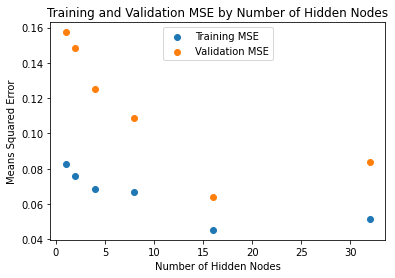

In [233]:
# Graph Validation Set MSE for each number of hidden nodes
test_accuracies = [10.1, 19.7, 30.0, 41.4, 55.6, 59.1]

n_hidden_by_train_mse = []
n_hidden_by_val_mse = []

for index, n_hidden in enumerate(hidden_values):
  results = hidden_layer_results.get(n_hidden)

  train_mse = results.get('mse_training_no_epoch')
  min_train = np.argmin(train_mse)
  
  val_mse = results.get('mse_validation_no_epoch')
  min_val = np.argmin(val_mse)

  n_hidden_by_train_mse.append([n_hidden, train_mse[min_train]])
  n_hidden_by_val_mse.append([n_hidden, val_mse[min_val]])

  print("Test Accuracy for num hidden = " + str(n_hidden) + " was " + str(test_accuracies[index]))


x1,y1 = zip(*n_hidden_by_train_mse)
x2,y2 = zip(*n_hidden_by_val_mse)

# Plot accuracy graph
plt.scatter(x1,y1, label="Training MSE")
plt.scatter(x2,y2, label="Validation MSE")

plt.xlabel("Number of Hidden Nodes")
plt.ylabel("Means Squared Error")
plt.title("Training and Validation MSE by Number of Hidden Nodes")
plt.legend(loc='upper center')
plt.show()

Despite doing most of my debugging and testing with hidden_size = [4] to match the initial debugging weights, it was great to get to see how the hidden_layers did have an effect on the outcomes as well. My best results came at n_hidden = 16, so I used those values for the rest of part 3 and 4. I did run this test a few times; occasionally the MSE stopped improving at n_hidden = 8, but for the most part, 16 was the magic number. Something between 8 and 16 would seem like a safe bet for this algorithm.

That said, its worth remembering that these are the best settings for one particular dataset with an already predetermined learning rate from the previous tests. If anything, doing this experimenting has highlighted the importance of things like grid search/random search in trying to find the best parameters for a project. Especially when the work is small like the datasets are for these projects, there is a lot of room to experiment and find what works best for the data you are working with. Just because the vowel data set worked best with lr=.25 and hidden size = [16], that does not mean the iris data set would work differently.

With regards to the number of hidden nodes specifically the results seem in line with what you would estimate based on the size of the data. It can be tempting to create a network with many hidden nodes and layers, but often its a waste of computational time since a network with less can do the same amount. Its the "too many cooks in the kitchen" issue.

This experiment reinforced the importance of parameter searching and the fact that when it comes to hidden nodes, less is usually more. Its better to search starting with a small value, then increasing from there, instead of the opposite.



## 3.3 (10%) Working with the Vowel Dataset - Momentum

Try some different momentum terms using the best number of hidden nodes and LR from your earlier experiments.

- Create a graph similar to step 3.2, but with momentum on the x-axis and number of epochs until validation set convergence on the y-axis.
- For each momentum term, print the test set accuracy. 
- You are trying to see how much momentum speeds up learning and how it affects accuracy.

In [237]:
# Train on each dataset
momentum_terms = [0.0, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
momentum_results = {}

test_accuracies = []

for momentum_val in momentum_terms:
  # Train on each dataset
  raw_data = loadarff('vowel.arff')
  dataset = pd.DataFrame(raw_data[0])

  X = dataset._get_numeric_data().to_numpy()
  y = dataset["Class"].to_numpy()
  y = pd.get_dummies(y).astype(int).to_numpy()

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Run each model with the designated momentum value
  model = MLP(hidden_layer_widths=[16], momentum=momentum_val, lr=.25, num_inputs=len(X[0]), num_outputs=len(y[0]))

  n_epochs = -1
  model = model.fit(X_train, y_train, epochs=n_epochs, zeros=False, validation_percent=.15)
  print("Model accuracy on test data: ", model.score(model.predict(X_test), y_test))
  test_accuracies.append(np.around((model.score(model.predict(X_test), y_test)*100), 1))
  
  # Save results of trial to momentum results dictionary
  momentum_results[momentum_val] = model.get_results()




Epoch # 1
Validation Accuracy:  0.20168067226890757
Change in accuracy:  0.20168067226890757



Epoch # 2
Validation Accuracy:  0.2605042016806723
Change in accuracy:  0.05882352941176472



Epoch # 3
Validation Accuracy:  0.3865546218487395
Change in accuracy:  0.12605042016806722



Epoch # 4
Validation Accuracy:  0.3277310924369748
Change in accuracy:  -0.05882352941176472



Epoch # 5
Validation Accuracy:  0.3949579831932773
Change in accuracy:  0.0672268907563025



Epoch # 6
Validation Accuracy:  0.4369747899159664
Change in accuracy:  0.04201680672268909



Epoch # 7
Validation Accuracy:  0.5210084033613446
Change in accuracy:  0.08403361344537819



Epoch # 8
Validation Accuracy:  0.4789915966386555
Change in accuracy:  -0.04201680672268909



Epoch # 9
Validation Accuracy:  0.5294117647058824
Change in accuracy:  0.05042016806722688



Epoch # 10
Validation Accuracy:  0.4789915966386555
Change in accuracy:  -0.05042016806722688



Epoch # 11
Validation Accuracy:  0.48739495

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:199: RuntimeWarning: overflow encountered in exp


Validation Accuracy:  0.08403361344537816
Change in accuracy:  0.008403361344537827



Epoch # 3
Validation Accuracy:  0.08403361344537816
Change in accuracy:  0.0



Epoch # 4
Validation Accuracy:  0.10084033613445378
Change in accuracy:  0.016806722689075626



Epoch # 5
Validation Accuracy:  0.10084033613445378
Change in accuracy:  0.0



Epoch # 6
Validation Accuracy:  0.10084033613445378
Change in accuracy:  0.0
Model accuracy on test data:  0.07575757575757576



Epoch # 1
Validation Accuracy:  0.1092436974789916
Change in accuracy:  0.1092436974789916



Epoch # 2
Validation Accuracy:  0.1092436974789916
Change in accuracy:  0.0



Epoch # 3
Validation Accuracy:  0.06722689075630252
Change in accuracy:  -0.04201680672268908



Epoch # 4
Validation Accuracy:  0.06722689075630252
Change in accuracy:  0.0



Epoch # 5
Validation Accuracy:  0.06722689075630252
Change in accuracy:  0.0



Epoch # 6
Validation Accuracy:  0.06722689075630252
Change in accuracy:  0.0
Model accuracy on t

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:192: RuntimeWarning: overflow encountered in add


Validation Accuracy:  0.06722689075630252
Change in accuracy:  0.0



Epoch # 3
Validation Accuracy:  0.06722689075630252
Change in accuracy:  0.0



Epoch # 4
Validation Accuracy:  0.06722689075630252
Change in accuracy:  0.0



Epoch # 5
Validation Accuracy:  0.06722689075630252
Change in accuracy:  0.0



Epoch # 6
Validation Accuracy:  0.06722689075630252
Change in accuracy:  0.0
Model accuracy on test data:  0.06060606060606061


Test Accuracy for momentum = 0.0 was 57.6%
Test Accuracy for momentum = 0.1 was 62.1%
Test Accuracy for momentum = 0.25 was 63.6%
Test Accuracy for momentum = 0.5 was 55.6%
Test Accuracy for momentum = 0.75 was 11.6%
Test Accuracy for momentum = 1.0 was 7.6%
Test Accuracy for momentum = 1.5 was 6.1%
Test Accuracy for momentum = 2.0 was 6.1%


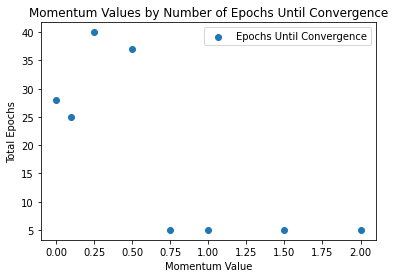

In [310]:
epochs_by_momentum = []

for index, momentum_val in enumerate(momentum_terms):
  results = momentum_results.get(momentum_val)

  epochs = results.get('epochs')
  total_epochs = epochs[-1]

  epochs_by_momentum.append([momentum_val, total_epochs])
  print("Test Accuracy for momentum = " + str(momentum_val) + " was " + str(test_accuracies[index]) + "%")


x1,y1 = zip(*epochs_by_momentum)

# Plot accuracy graph
plt.scatter(x1,y1, label="Epochs Until Convergence")

plt.xlabel("Momentum Value")
plt.ylabel("Total Epochs")
plt.title("Momentum Values by Number of Epochs Until Convergence")
plt.legend(loc='upper right')
plt.show()

Looking at the graph of the outcomes of the experiment, the large scale shape is more or less what is expected; a downwards curve. That means that as momentum increases on the x-axis, the number of epochs until convergence is decreasing, resulting in a sort of negative exponential curve. 

At first glance that seems obvious that higher momentum would speed up learning, but it is important to also assess the quality of the learning. In my test results, the momentum values between 0 and 0.5 had fairly decent results for the test set accuracy, somewhere between 55% and 63%. Not great, but respectable. As soon as momentum exceeded this, the number of epochs plummetted but so did the test accuracy. Momentum = 0.75 had a test accuracy of 11.6% and it only got worse from there.

It makes sense how momentum speeds up learning; by adding a constant term to the derivatives calculated in the back_propagation step, you are just increasing the amount of change in the already specified direction. If the gradient step is negative, you go further negative, and vice versa. This works great if you are facing in the correct direction, but can have very bad effects if you are misguided. Similar to how learning rate can lead to overshooting, momentum can have a similar effect, by having that constant value added into the equation.

As a result, it is all about finding that balance between training time and training results for choosing a momentum. If time is a constaint, and it very well can be a serious one if you are training on a very large dataset and with limited resources, you may need to sacrifice some accuracy for the speed of training. If time is less of a concern, it may do well to scale back on momentum if it appears to have a negative impact on training.

Just like the other parameters, it is all a fine balance, and all I can do as a researcher is try different values, and see what produces the best results across a variety of metrics.


## 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris and Vowel data sets.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [243]:
# Load data sets above so I only need to one time
# Load Iris Dataset
raw_data = loadarff('iris.arff')
dataset = pd.DataFrame(raw_data[0])

X = dataset._get_numeric_data().to_numpy()
y = dataset["class"].to_numpy()
y = pd.get_dummies(y).astype(int).to_numpy()

X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X, y, test_size=0.2, random_state=42)


# Load Vowel Dataset
raw_data = loadarff('vowel.arff')
dataset = pd.DataFrame(raw_data[0])

X = dataset._get_numeric_data().to_numpy()
y = dataset["Class"].to_numpy()
y = pd.get_dummies(y).astype(int).to_numpy()

X_train_vowel, X_test_vowel, y_train_vowel, y_test_vowel = train_test_split(X, y, test_size=0.2, random_state=42)

In [284]:
# Load sklearn perceptron (with all default settings for tweaking)
''' 
Hyper Parameters to try:

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping
'''

clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(100,), activation="relu", 
                    learning_rate_init=0.001, alpha=0.0001, momentum=0.9, 
                    nesterovs_momentum=True, solver='adam', early_stopping=False)

In [288]:
# Load my model and adjust settings from here
model = MLP(hidden_layer_widths=[100], momentum=.9, lr=.25, num_inputs=len(X_train_iris[0]), num_outputs=len(y_train_iris[0]))
n_epochs = -1

### Comparisons between SciKit Learn MLP vs. My Model

In [263]:
# My Model vs. Scikit matching hyper-parameters to my best outputs from testing (lr=.001, momentum=.5, hidden size=16) for Iris Data
model = model.fit(X_train_iris, y_train_iris, epochs=n_epochs, zeros=False, validation_percent=.15)
print("Model accuracy on Iris test data: ", model.score(model.predict(X_test_iris), y_test_iris))

clf.fit(X_train_iris, y_train_iris)
print("Scikit Accuracy on Iris Test Data: ", clf.score(X_test_iris, y_test_iris))

Model accuracy on Iris test data:  0.8
Scikit Accuracy on Iris Test Data:  0.4


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [267]:
# My Model vs. Scikit with matching default settings (lr=.001, momentum=.5, hidden size=16) for Vowel Data
model = model.fit(X_train_vowel, y_train_vowel, epochs=n_epochs, zeros=False, validation_percent=.15)
print("Model accuracy on Vowel test data: ", model.score(model.predict(X_test_vowel), y_test_vowel))

clf.fit(X_train_vowel, y_train_vowel)
print("Scikit Accuracy on Vowel Test Data: ", clf.score(X_test_vowel, y_test_vowel))

Model accuracy on Vowel test data:  0.6515151515151515
Scikit Accuracy on Vowel Test Data:  0.13131313131313133


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [289]:
# Now compared to Scikit output using the out of the box default settings (lr=.001, momentum=.9, hidden size=100) for Iris Data
model = model.fit(X_train_iris, y_train_iris, epochs=n_epochs, zeros=False, validation_percent=.15)
print("Model accuracy on Iris test data: ", model.score(model.predict(X_test_iris), y_test_iris))

clf.fit(X_train_iris, y_train_iris)
print("Scikit Accuracy on Iris Test Data: ", clf.score(X_test_iris, y_test_iris))

Model accuracy on Iris test data:  0.3
Scikit Accuracy on Iris Test Data:  0.8333333333333334


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [287]:
# Now compared to Scikit output using the out of the box default settings (lr=.001, momentum=.9, hidden size=100) for Vowel Data
model = model.fit(X_train_vowel, y_train_vowel, epochs=n_epochs, zeros=False, validation_percent=.15)
print("Model accuracy on Vowel test data: ", model.score(model.predict(X_test_vowel), y_test_vowel))

clf.fit(X_train_vowel, y_train_vowel)
print("Scikit Accuracy on Vowel Test Data: ", clf.score(X_test_vowel, y_test_vowel))

Model accuracy on Vowel test data:  0.09595959595959595
Scikit Accuracy on Vowel Test Data:  0.4595959595959596


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


### Experiments with SciKit Learn MLP and Vowel Dataset

In [299]:
# Experimenting to find best hyper parameters for scikit learn multilayer on vowel dataset:

clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(100,), activation="logistic", 
                    learning_rate_init=0.001, alpha=0.0001, momentum=0.9, 
                    nesterovs_momentum=True, solver='adam', early_stopping=False)

print("Change activation: relu -> sigmoid")

clf.fit(X_train_vowel, y_train_vowel)
print("Scikit Accuracy on Vowel Test Data: ", clf.score(X_test_vowel, y_test_vowel))


clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(100,), activation="relu", 
                    learning_rate_init=0.1, alpha=0.0001, momentum=0.9, 
                    nesterovs_momentum=True, solver='adam', early_stopping=False)

print("Change learning rate: 0.001 -> 0.1")

clf.fit(X_train_vowel, y_train_vowel)
print("Scikit Accuracy on Vowel Test Data: ", clf.score(X_test_vowel, y_test_vowel))


clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(100,), activation="relu", 
                    learning_rate_init=0.001, alpha=0.0001, momentum=0.9, 
                    nesterovs_momentum=True, solver='sgd', early_stopping=False)

print("Change: Using Nesterovs Momentum (must switch solver to sgd)")
clf.fit(X_train_vowel, y_train_vowel)
print("Scikit Accuracy on Vowel Test Data: ", clf.score(X_test_vowel, y_test_vowel))

clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(100,), activation="relu", 
                    learning_rate_init=0.1, alpha=0.0001, momentum=0.9, 
                    nesterovs_momentum=True, solver='sgd', early_stopping=False)

print("Using Nesterovs Momentum (must switch solver to sgd), change: learning rate -> 0.1")
clf.fit(X_train_vowel, y_train_vowel)
print("Scikit Accuracy on Vowel Test Data: ", clf.score(X_test_vowel, y_test_vowel))


clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(100,), activation="relu", 
                    learning_rate_init=0.1, alpha=0.0001, momentum=0.9, 
                    nesterovs_momentum=True, solver='sgd', early_stopping=True)

print("Keeping previous settings, turn early stopping on")
clf.fit(X_train_vowel, y_train_vowel)
print("Scikit Accuracy on Vowel Test Data: ", clf.score(X_test_vowel, y_test_vowel))


clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(100,), activation="relu", 
                    learning_rate_init=0.1, alpha=0.01, momentum=0.9, 
                    nesterovs_momentum=True, solver='sgd', early_stopping=False)

print("Early stopping back off, change alpha -> 0.01")
clf.fit(X_train_vowel, y_train_vowel)
print("Scikit Accuracy on Vowel Test Data: ", clf.score(X_test_vowel, y_test_vowel))

clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(100,100), activation="relu", 
                    learning_rate_init=0.1, alpha=0.01, momentum=0.9, 
                    nesterovs_momentum=True, solver='sgd', early_stopping=False)

print("Keep previous settings, add second hidden layer of same size")
clf.fit(X_train_vowel, y_train_vowel)
print("Scikit Accuracy on Vowel Test Data: ", clf.score(X_test_vowel, y_test_vowel))

Change activation: relu -> sigmoid


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.13636363636363635
Change learning rate: 0.001 -> 0.1
Scikit Accuracy on Vowel Test Data:  0.7171717171717171
Change: Using Nesterovs Momentum (must switch solver to sgd)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.09595959595959595
Using Nesterovs Momentum (must switch solver to sgd), change: learning rate -> 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.8333333333333334
Keeping previous settings, turn early stopping on
Scikit Accuracy on Vowel Test Data:  0.43434343434343436
Early stopping back off, change alpha -> 0.01


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.8282828282828283
Keep previous settings, add second hidden layer of same size
Scikit Accuracy on Vowel Test Data:  0.8282828282828283


I performed tests in two sets, comparing my model vs. the SciKit Learn MLP using "default" parameters of each one for the two data sets, and experimenting just with the MLP to try and "beat the high score" on the vowel dataset.

1. For testing the two models, I first used "my default settings" (lr=.25, momentum=.5, hidden_size = [16]), the settings that worked best on the vowel dataset from the searching in part 3. Surprisingly enough, my model outperformed the MLP on both the Iris and Vowel datasets. 

```
Model accuracy on Iris test data:  0.8
Scikit Accuracy on Iris Test Data:  0.4

Model accuracy on Vowel test data:  0.6515151515151515
Scikit Accuracy on Vowel Test Data:  0.13131313131313133
```

At first I was surprised, but then I thought about the default settings of the MLP. It was a much larger model, defaulting to 100 hidden nodes, a momentum of .9 and a learning rate of 0.001. I decided to reverse the playing field and compare the models using those default settings.

```
Model accuracy on Iris test data:  0.3
Scikit Accuracy on Iris Test Data:  0.8333333333333334

Model accuracy on Vowel test data:  0.09595959595959595
Scikit Accuracy on Vowel Test Data:  0.4595959595959596
```

The MLP did not perform astonishingly well on the two sets, but my model struggled heavily. My experimenting from before showed that my model did not perform well with a very low learning rate, so I think that was probably the biggest factor. The next biggest factor would be the momentum, since I saw that momentum above .5 caused very early convergence and low accuracy. I don't think hidden layer size had a large effect on the low accuracy.

In the end, I was reminded that each model varies by implementation, so the same data and mostly same parameters can have very different results. On top of this, there are always random elements such as stochastic weight initialization and such that can make the results seem better or worse than they actually are, so more testing is always better to be confident in the results.

2. For the second set of testing, I took a MLP and continued to tweak knobs and levers, trying to out do my best accuracy on the same data set. I made sure to reinitialize the MLP each time I changed a hyper parameter, so I know that it wasn't learning over multiple calls to fit. 

Of the hyper parameters I changed, I saw the most postive impact when I changed the learning rate and the alpha (regularization coefficient). The learning rate especially stood out; one iteration changing it from 0.001 to 0.1 increased accuracy by almost 60%. I think in this situation especially, the change was dramatic since the dataset is so small, increasing the learning rate is safe since there aren't as many dimensions to descend on the gradient so the boost in speed to learning helps move along without getting stuck. 

On the other hand, I saw a negative/neutral result with things like changing momentum to Nesterovs momentum, using early stopping, and changing hidden size. Early stopping was the main culprit, which isn't too surprising given the nature of the parameter. The other two had just a neutral effect when I used then; there was a very slight accuracy increase with Nestrovs Momenutm, but no change at all when I doubled the hiddden size/layers.

Since my experimenting here was just following curiousity it is okay, but as always it is a lot more effective to move knobs one at a time instead of trying to adjust a couple parameters at a time. Sometimes it works, and experience and feel with machine learning would help me to be more used to making these adjustments, but generally speaking, methods like grid search simplify the process and make things more consistent and time efficient.



## 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid/random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [304]:
# Load voting data
raw_data = loadarff('voting-dataset.arff')
all_data = pd.DataFrame(raw_data[0], dtype=np.float).to_numpy()

# Set up data for training
data_len = len(all_data[0])

X = [([0 if value[i] == b'n' else 1 for i in range(data_len-1)]) for value in all_data]
for sublist in X:
  sublist.append(1)

y = [0 if value[data_len-1] == b'republican' else 1 for value in all_data]


[[0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1], [0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1], [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1], [0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1], [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1], [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1], [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1], [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1], [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1], [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1], [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1], [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1], [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1], [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1], [1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  This is separate from the ipykernel package so we can avoid doing imports until


In [307]:
# Split voting data into test, train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Load sklearn perceptron
learning_rates = [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1.0]
momentum_vals = [0.01, 0.1, 0.2, 0.25, 0.42, 0.5, 0.66, 0.75, 1.0]
hidden_sizes = [[10], [10,20], [25, 25, 25], [100], [100, 100], [10, 50, 100, 200]]

best_score = 0
best_settings = []

for lr in learning_rates:
  for momentum_val in momentum_vals:
    for size in hidden_sizes:

      # Initialize new MLP with default settings except these hyper parameters
      clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=size, activation="relu", 
                    learning_rate_init=lr, alpha=0.0001, momentum=momentum_val, 
                    nesterovs_momentum=True, solver='adam', early_stopping=False)

      # Output current settings of grid search
      print("Learning Rate: {}, Momentum: {}, Hidden Size: {}".format(lr, momentum_val, size))

      # Train on voting dataset
      clf.fit(X_train, y_train)

      score = clf.score(X_test, y_test) 

      # Output accuracy value 
      print("Scikit Accuracy on Voting Test Data: ", score)

      if score > best_score:
        print("New best accuracy!!!")
        best_score = score
        best_settings = [lr, momentum_val, size]

Learning Rate: 0.001, Momentum: 0.01, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
New best accuracy!!!
Learning Rate: 0.001, Momentum: 0.01, Hidden Size: [10, 20]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 0.01, Hidden Size: [25, 25, 25]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 0.01, Hidden Size: [100]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 0.01, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.946236559139785
New best accuracy!!!
Learning Rate: 0.001, Momentum: 0.01, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
New best accuracy!!!
Learning Rate: 0.001, Momentum: 0.1, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 0.1, Hidden Size: [10, 20]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 0.1, Hidden Size: [25, 25, 25]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 0.1, Hidden Size: [100]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 0.1, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.946236559139785
Learning Rate: 0.001, Momentum: 0.1, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.001, Momentum: 0.2, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 0.2, Hidden Size: [10, 20]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 0.2, Hidden Size: [25, 25, 25]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 0.2, Hidden Size: [100]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 0.2, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.946236559139785
Learning Rate: 0.001, Momentum: 0.2, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.001, Momentum: 0.25, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 0.25, Hidden Size: [10, 20]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 0.25, Hidden Size: [25, 25, 25]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 0.25, Hidden Size: [100]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 0.25, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.946236559139785
Learning Rate: 0.001, Momentum: 0.25, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.001, Momentum: 0.42, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 0.42, Hidden Size: [10, 20]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 0.42, Hidden Size: [25, 25, 25]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 0.42, Hidden Size: [100]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 0.42, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.946236559139785
Learning Rate: 0.001, Momentum: 0.42, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.001, Momentum: 0.5, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 0.5, Hidden Size: [10, 20]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 0.5, Hidden Size: [25, 25, 25]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 0.5, Hidden Size: [100]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 0.5, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.946236559139785
Learning Rate: 0.001, Momentum: 0.5, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.001, Momentum: 0.66, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 0.66, Hidden Size: [10, 20]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 0.66, Hidden Size: [25, 25, 25]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 0.66, Hidden Size: [100]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 0.66, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.946236559139785
Learning Rate: 0.001, Momentum: 0.66, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.001, Momentum: 0.75, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 0.75, Hidden Size: [10, 20]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 0.75, Hidden Size: [25, 25, 25]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 0.75, Hidden Size: [100]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 0.75, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.946236559139785
Learning Rate: 0.001, Momentum: 0.75, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.001, Momentum: 1.0, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 1.0, Hidden Size: [10, 20]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 1.0, Hidden Size: [25, 25, 25]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9247311827956989
Learning Rate: 0.001, Momentum: 1.0, Hidden Size: [100]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.001, Momentum: 1.0, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.946236559139785
Learning Rate: 0.001, Momentum: 1.0, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.01, Momentum: 0.01, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.01, Hidden Size: [10, 20]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 0.01, Hidden Size: [25, 25, 25]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 0.01, Hidden Size: [100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.01, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.01, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.01, Momentum: 0.1, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.1, Hidden Size: [10, 20]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 0.1, Hidden Size: [25, 25, 25]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 0.1, Hidden Size: [100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.1, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.1, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.01, Momentum: 0.2, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.2, Hidden Size: [10, 20]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 0.2, Hidden Size: [25, 25, 25]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 0.2, Hidden Size: [100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.2, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.2, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.01, Momentum: 0.25, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.25, Hidden Size: [10, 20]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 0.25, Hidden Size: [25, 25, 25]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 0.25, Hidden Size: [100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.25, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.25, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.01, Momentum: 0.42, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.42, Hidden Size: [10, 20]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 0.42, Hidden Size: [25, 25, 25]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 0.42, Hidden Size: [100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.42, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.42, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.01, Momentum: 0.5, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.5, Hidden Size: [10, 20]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 0.5, Hidden Size: [25, 25, 25]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 0.5, Hidden Size: [100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.5, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.5, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.01, Momentum: 0.66, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.66, Hidden Size: [10, 20]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 0.66, Hidden Size: [25, 25, 25]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 0.66, Hidden Size: [100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.66, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.66, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.01, Momentum: 0.75, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.75, Hidden Size: [10, 20]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 0.75, Hidden Size: [25, 25, 25]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 0.75, Hidden Size: [100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.75, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 0.75, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.01, Momentum: 1.0, Hidden Size: [10]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 1.0, Hidden Size: [10, 20]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 1.0, Hidden Size: [25, 25, 25]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.01, Momentum: 1.0, Hidden Size: [100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 1.0, Hidden Size: [100, 100]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.01, Momentum: 1.0, Hidden Size: [10, 50, 100, 200]
Scikit Accuracy on Vowel Test Data:  0.978494623655914
Learning Rate: 0.1, Momentum: 0.01, Hidden Size: [10]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.1, Momentum: 0.01, Hidden Size: [10, 20]
Scikit Accuracy on Vowel Test Data:  0.9354838709677419
Learning Rate: 0.1, Momentum: 0.01, Hidden Size: [25, 25, 25]
Scikit Accuracy on Vowel Test Data:  0.956989247311828
Learning Rate: 0.1, Mome

In [309]:
print("Highest accuracy value: ", best_score)
print("Best settings from grid search: lr = {}, momentum = {}, hidden_size = {}".format(best_settings[0], best_settings[1], best_settings[2]))

Highest accuracy value:  0.978494623655914
Best settings from grid search: lr = 0.001, momentum = 0.01, hidden_size = [10, 50, 100, 200]


For my grid search, I chose to just adjust numerical parameters since it would be easy to nest arrays and pass each value in one at a time to automate the process. I used the parameters learning rate, momentum and hidden size. These were also interesting to me since they are the main hyper parameters I can control on my model, so I was curious to see what settings worked best for the MLP so I could try them on my model a different time.

The result of my testing was that learning rate = 0.001, momentum = 0.01 and hidden size = [10,50,100,200] were the best results, getting an accuracy of 97.9% on the voting data set. As I scrolled through the output, there were multiple high 90 values, especially 95.x% results which would only be 1 or 2 classification misses away from tying the high. This just proves that while there are better and worse settings, it is not always a simple black and white answer. Usually there are multiple good settings that are worth looking at and experimenting further with.

Since these datasets are small and simple, the best thing I could do if I wanted to continue working on this would be maybe to keep the 5 best results and use those in testing with other datasets. The computation time is short so it doesn't hurt me to try these parameters in a different context and see if its a better general setting for the model, or if it just works in that specific case.

## 5. (Optional 5% Extra credit) For the vowel data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, and momentum.  

- Compare and discuss the values found with the ones you found in part 3.


*Discuss findings here*